In [1]:
using Plots
using StatsPlots
using JLD2
using MPSTime
using StatsBase
using Measures
using LaTeXStrings
using Pickle
# using Makie
# using CairoMakie

In [3]:
function map_to_pm(windows, pms)
    l = maximum(vcat(windows...))
    inds = [ argmin(abs.(pms .- length(w)/l*100)) for w in windows]
    return pms[inds]
end

function sort_by_pms(results, windows, pms)
    percs = map_to_pm(windows, pms)
    res_by_pm = []
    for pm in pms
        push!(res_by_pm, results[percs .== pm])
    end
    return res_by_pm
end

function sort_by_pms(fold, pms)

    return sort_by_pms(fold["loss"], fold["eval_windows"], pms)
end

function loss_by_pm(res, pms; scale::Float64 = 1.)
    losses = map(f -> sort_by_pms(f, pms) ./ scale, res) 
    # return mapreduce(f -> sort_by_pms(f, pms), +, res) / length(res)
    pm_mean = [mean.(l) for l in losses]
    return mean(losses), std(hcat(pm_mean...); dims=2)

end

function mmae_std_by_pm(res, pms; scale::Float64 = 1.)
    mean_by_pm, std_by_pm = loss_by_pm(res, pms; scale=scale)

    return mean.(mean_by_pm), std_by_pm
end

mmae_std_by_pm (generic function with 1 method)

In [4]:
function hm_convert(xs,ys,zs, annotations=false; verbosity=0)
    xs_full = range(extrema(xs)...)
    ys_full = range(extrema(ys)...)

    zs_full = Matrix{Union{Float64,Missing}}(missing, length(ys_full), length(xs_full))

    scale = ones(Int, size(zs_full)...)
    dupes = 0
    n = length(zs)
    anns = Dict{Tuple, Any}()
    for (i, z) in enumerate(zs)
        xi = findfirst(==(xs[i]), xs_full)
        yi = findfirst(==(ys[i]), ys_full)

        if ismissing(zs_full[yi, xi])
            zs_full[yi, xi] = z

        else
            zs_full[yi, xi] += z
            scale[yi, xi] += 1
            dupes += 1
        end
        anns[xs[i], ys[i]] =  text("$(scale[yi,xi])", halign=:center, valign=:center, color=:white)

    end
    verbosity >= 1 && println("n=$n, Duplicates=$dupes")

    if annotations
        xs_ann, ys_ann, ts_ann = [],[],[]
        for ((x,y), text) in pairs(anns)
            push!(xs_ann, x)
            push!(ys_ann, y)
            push!(ts_ann, text)
        end
        return xs_full, ys_full, (zs_full ./= scale), (xs_ann, ys_ann, ts_ann)

    else

        return xs_full, ys_full, (zs_full ./= scale)
    end
end

function loss_opts(res; verbosity=0)
    losses = getindex.(res,"loss") .|> mean
    opts = getindex.(res, "opts")

    ds = getproperty.(opts, :d)
    chis = getproperty.(opts, :chi_max)
    etas = getproperty.(opts, :eta)
    nsw = getproperty.(opts, :nsweeps)
    return losses, ds, chis, nsw, etas
end

function get_hm_vals(res, annotations=true; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    return hm_convert(chis, ds, losses, annotations; verbosity=verbosity)
end

function map_dupes(res; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    pairs = zip(ds, chis, nsw) |> collect
    return countmap(pairs)
end

map_dupes (generic function with 1 method)

In [5]:
pms = 5:10:95

@load "IPD/IPD_rand_250_ns.jld2" res
res_IPD = copy(res)


mmae_IPD, std_IPD = mmae_std_by_pm(res_IPD, pms)

([0.15502125514042406, 0.15757557937914263, 0.1699442716037779, 0.16538645956016482, 0.17311799237602532, 0.17794088407082712, 0.18880712495924512, 0.19647745530360747, 0.21110095465738396, 0.24962740193561894], [0.01027152715145583; 0.010365083773918562; … ; 0.010461231368960358; 0.015796101460624472;;])

In [8]:
f = jldopen("Josh/IPD/IPD_ImputationFinalResults_30Fold.jld2", "r");
res_IPD_paper = read(f, "mps_results")
res_IPD_nn = read(f, "nn_results")
close(f)

instances = length(res_IPD_paper[5][1])
mmae_IPD_paper = [mean([mean([mean(res_IPD_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_IPD_nn = [mean([mean([mean(res_IPD_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_IPD_paper = ([std([mean([mean(res_IPD_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_IPD_nn = ([std([mean([mean(res_IPD_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

10-element Vector{Float64}:
 0.008329537431858061
 0.008320325357159352
 0.008781910627708788
 0.008269664558263471
 0.008628720460549738
 0.009152587501041793
 0.009350555083258895
 0.009422439061856134
 0.009649422581143085
 0.01397327114562047

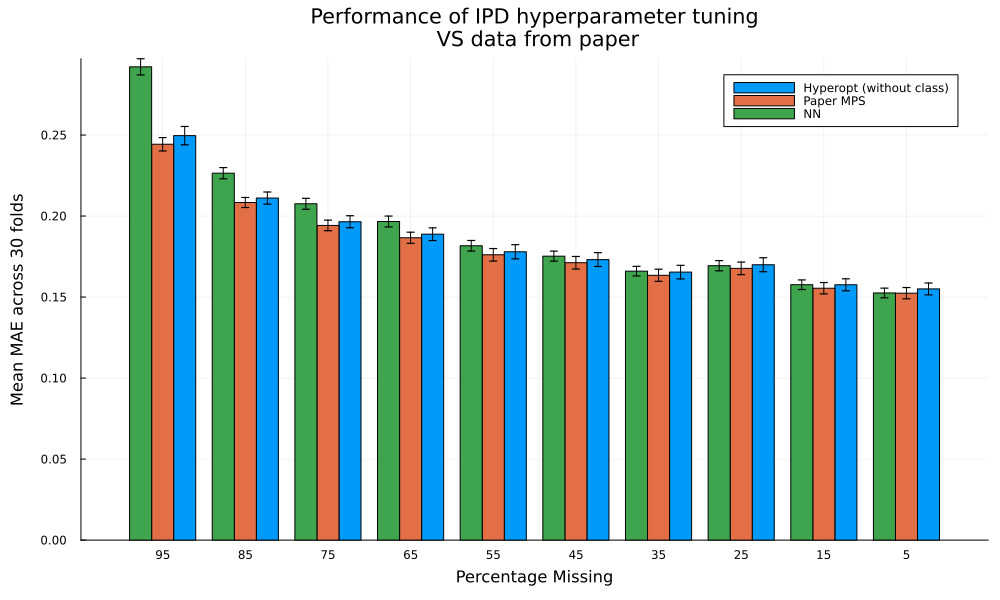

In [9]:
groupedbar(
    pms, 
    [ mmae_IPD  mmae_IPD_paper mmae_IPD_nn ]; 
    yerr =1.96 .* [std_IPD  std_IPD_paper std_IPD_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of IPD hyperparameter tuning\n VS data from paper")
# savefig("ipd.png")

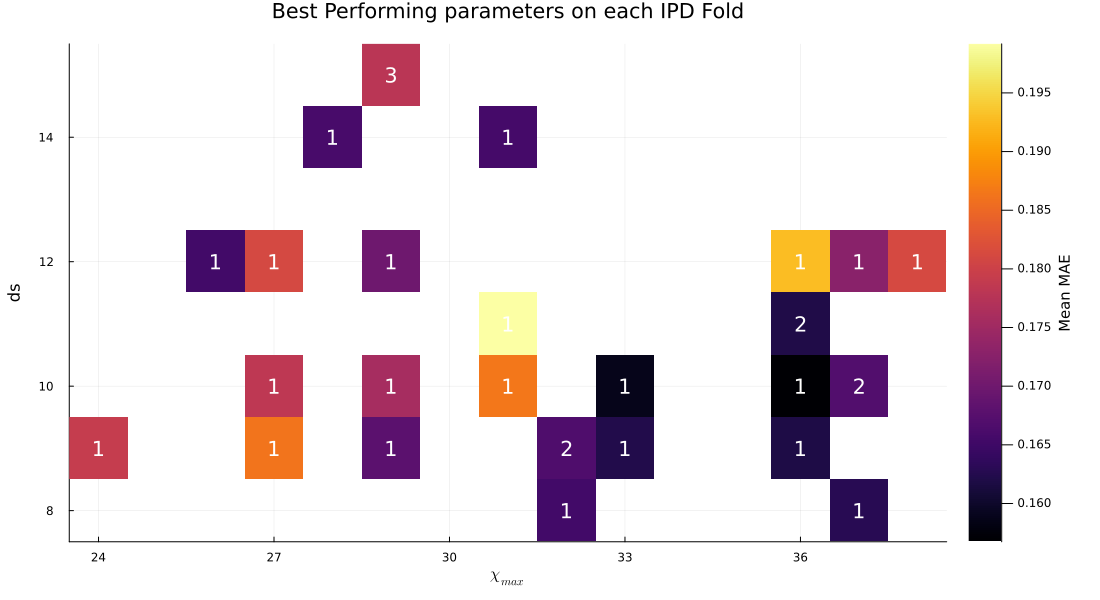

In [10]:
ds, chis, losses, anns = get_hm_vals(res_IPD)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each IPD Fold")
plot(hm)
# savefig("IPD_heatmap.png")


# ECG

In [11]:
pms = 5:10:95

@load "ECG200/ECG_rand_250_ns.jld2" res
res_ECG = copy(res)


mmae_ECG, std_ECG = mmae_std_by_pm(res_ECG, pms)

([0.21620518598673102, 0.22314240674350364, 0.21939444892185084, 0.21923911333964646, 0.22743282316711289, 0.2433248437903279, 0.2531289808992191, 0.26057458068689104, 0.3020011981964288, 0.38238181179436614], [0.007402562399329372; 0.007768501299639522; … ; 0.013134015652216733; 0.01778310612347809;;])

In [12]:
f = jldopen("Josh/ECG/ECG200_ImputationFinalResults_30Fold.jld2", "r");
res_ECG_paper = read(f, "mps_results")
res_ECG_nn = read(f, "nn_results")
close(f)

instances = length(res_ECG_mps[5][1])
mmae_ECG_paper = [mean([mean([mean(res_ECG_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_ECG_nn = [mean([mean([mean(res_ECG_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_ECG_paper = ([std([mean([mean(res_ECG_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_ECG_nn = ([std([mean([mean(res_ECG_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

UndefVarError: UndefVarError: `res_ECG_mps` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
groupedbar(
    pms, 
    [ mmae_ECG  mmae_ECG_paper mmae_ECG_nn ]; 
    yerr =1.96 .* [std_ECG  std_ECG_paper std_ECG_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of ECG200 hyperparameter tuning\n VS data from paper")
# savefig("ECG200.png")

UndefVarError: UndefVarError: `mmae_ECG_paper` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

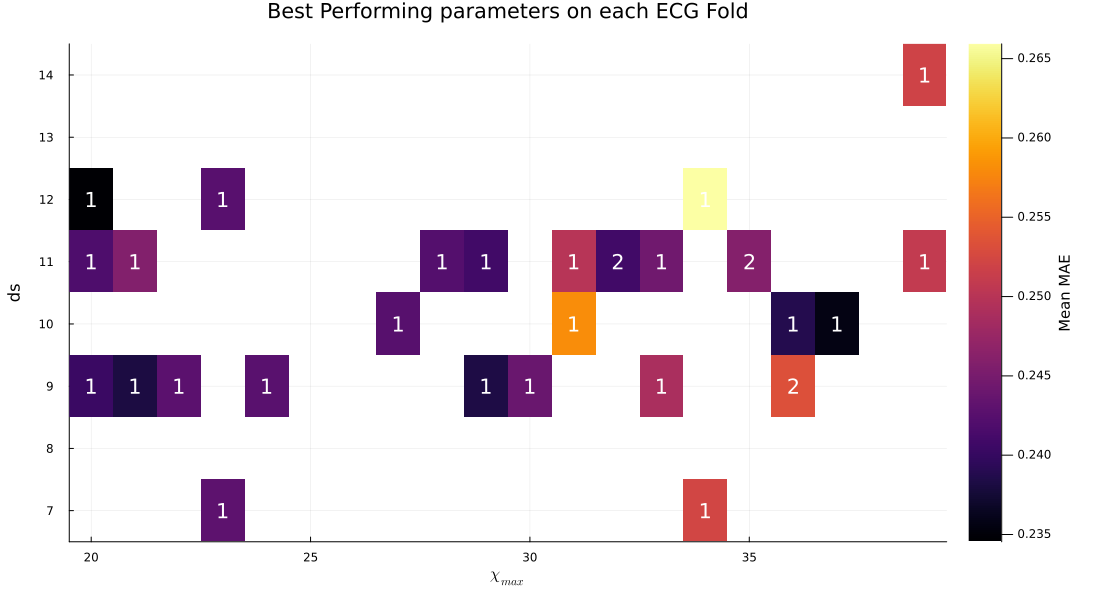

In [14]:
ds, chis, losses, anns = get_hm_vals(res_ECG)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG Fold")
plot(hm)
# savefig("ECG_heatmap.png")


# Kepler

In [26]:
pms = 5:10:95
@load "Kepler/KCGD_nn/insts_1_to_5.jld2" loss_NN_per_inst

res_kepGD = []
mmae_kepGD = Matrix{Float64}(undef, 5, length(pms))
std_kepGD = Matrix{Float64}(undef, 5, length(pms))
res_kepC6 = []
mmae_kepC6 = Matrix{Float64}(undef, 5, length(pms))
std_kepC6 = Matrix{Float64}(undef, 5, length(pms))

mmae_kepGD_nn = Matrix{Float64}(undef, 5, length(pms))
std_kepGD_nn = Matrix{Float64}(undef, 5, length(pms))

kepGD_opts = []


for i in 1:5
    @load "Kepler/KCGD_evals_$i/ImputationLoss()_MPSRandomSearch(:LatinHypercube)_f=30_cv=5_iters=250.jld2" res
    mmae_kepGD[i,:], std_kepGD[i,:] = mmae_std_by_pm(res, pms)
    push!(kepGD_opts, getindex.(res,"opts"))
    push!(res_kepGD, res)

    mmae_kepGD_nn[i,:], std_kepGD_nn[i,:] = mmae_std_by_pm(loss_NN_per_inst[i], pms) 


    @load "Kepler/KC6_evals_$i/ImputationLoss()_MPSRandomSearch(:LatinHypercube)_f=30_cv=5_iters=250.jld2" res
    mmae_kepC6[i,:], std_kepC6[i,:] = mmae_std_by_pm(res, pms)
    push!(res_kepC6, res)


end



In [8]:
@load "KC6_paper.jld2" mmae_paper_mps_c6 std_paper_mps_c6 mmae_nn_c6 std_nn_c6

4-element Vector{Symbol}:
 :mmae_paper_mps_c6
 :std_paper_mps_c6
 :mmae_nn_c6
 :std_nn_c6

In [9]:
@load "Kepler/python/results/GD_pyalgs.jld2" mmae_kepGD_britsi std_kepGD_britsi mmae_kepGD_cdrec std_kepGD_cdrec mmae_kepGD_csdi std_kepGD_csdi
@load "Kepler/python/results/C6_britsi.jld2" mmae_kepC6_britsi std_kepC6_britsi

2-element Vector{Symbol}:
 :mmae_kepC6_britsi
 :std_kepC6_britsi

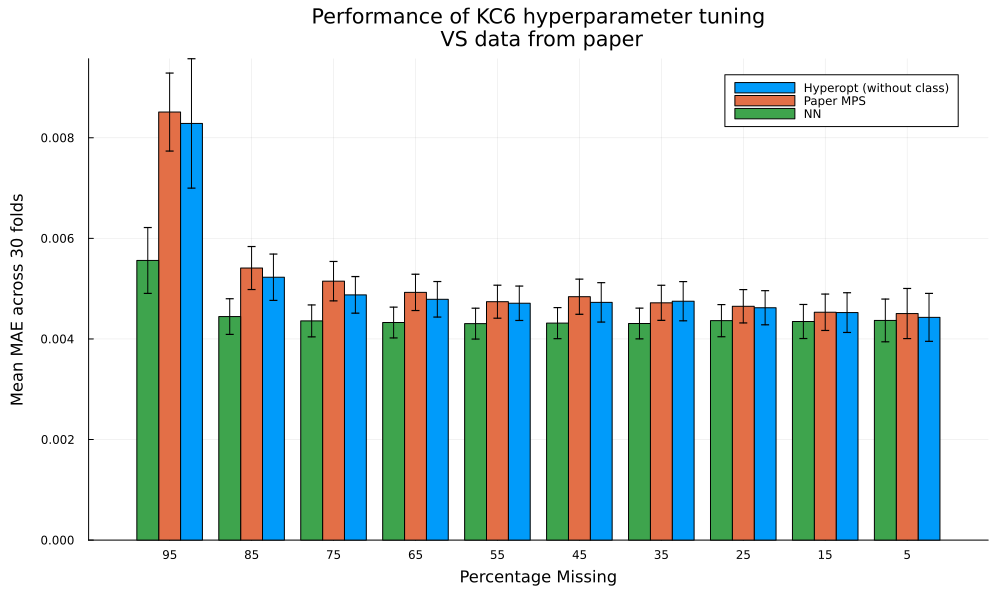

In [10]:
inst = 1
groupedbar(
    pms, 
    [ mmae_kepC6[inst,:]  mmae_paper_mps_c6[inst,:] mmae_nn_c6[inst,:] ]; 
    yerr =1.96 .* [std_kepC6[inst,:]  std_paper_mps_c6[inst,:] std_nn_c6[inst,:] ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of KC6 hyperparameter tuning\n VS data from paper")
# savefig("ECG200.png")

In [ ]:
inst = 1
mmae_kepC6_5mean,  mmae_paper_mps_c6_5mean, mmae_nn_c6_5mean, mmae_britsi_c6_5mean = (
    mean(mmae_kepC6; dims=1)',  
    mean(mmae_paper_mps_c6[1:5,:]; dims=1)', 
    mean(mmae_nn_c6[1:5,:]; dims=1)',
    mean(mmae_kepC6_britsi[1:5,:]; dims=1)'
)

std_kepC6_5mean,  std_paper_mps_c6_5mean, std_nn_c6_5mean, std_britsi_c6_5mean = (
    mean(std_kepC6; dims=1)',  
    mean(std_paper_mps_c6[1:5,:]; dims=1)', 
    mean(std_nn_c6[1:5,:]; dims=1)',
    mean(std_kepC6_britsi[1:5,:]; dims=1)',
)


groupedbar(
    pms, 
    [mmae_nn_c6_5mean mmae_kepC6_5mean  mmae_paper_mps_c6_5mean  mmae_britsi_c6_5mean ]; 
    yerr =1.96 .* [std_nn_c6_5mean std_kepC6_5mean std_paper_mps_c6_5mean std_britsi_c6_5mean] ./sqrt(30), 
    xticks = pms, 
    labels=["NN" "MPSTime" "Old MPS" "Britsi"], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
ylims!(0.,0.0075)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Kepler RR Imputation")
# savefig("KepRR.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/KepRR.png"

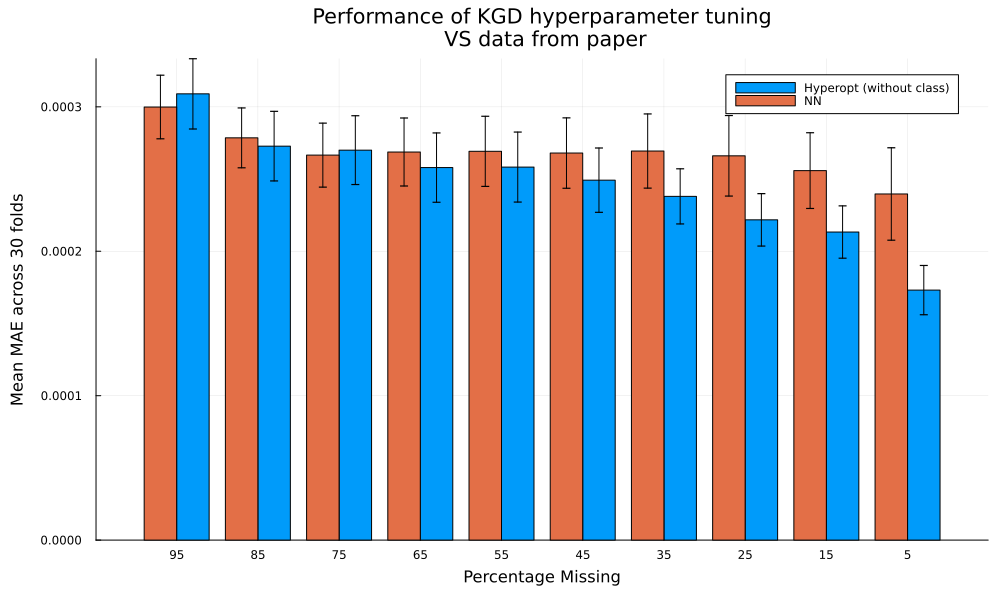

In [25]:
inst = 1
groupedbar(
    pms, 
    [ mmae_kepGD[inst,:]  mmae_kepGD_nn[inst,:] ]; 
    yerr =1.96 .* [ std_kepGD[inst,:]  std_kepGD_nn[inst,:] ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of KGD hyperparameter tuning\n VS data from paper")
# savefig("ECG200.png")

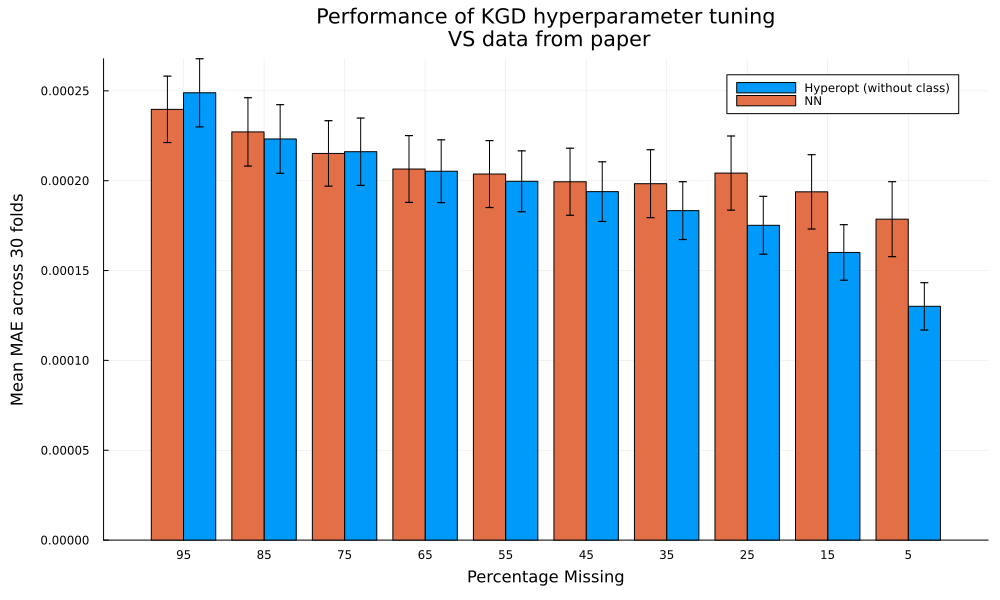

In [26]:
inst = 1
groupedbar(
    pms, 
    [ mean(mmae_kepGD, dims=1)'  mean(mmae_kepGD_nn, dims=1)' ]; 
    yerr =1.96 .* [ mean(std_kepGD, dims=1)'  mean(std_kepGD_nn, dims=1)' ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of KGD hyperparameter tuning\n VS data from paper")
# savefig("ECG200.png")

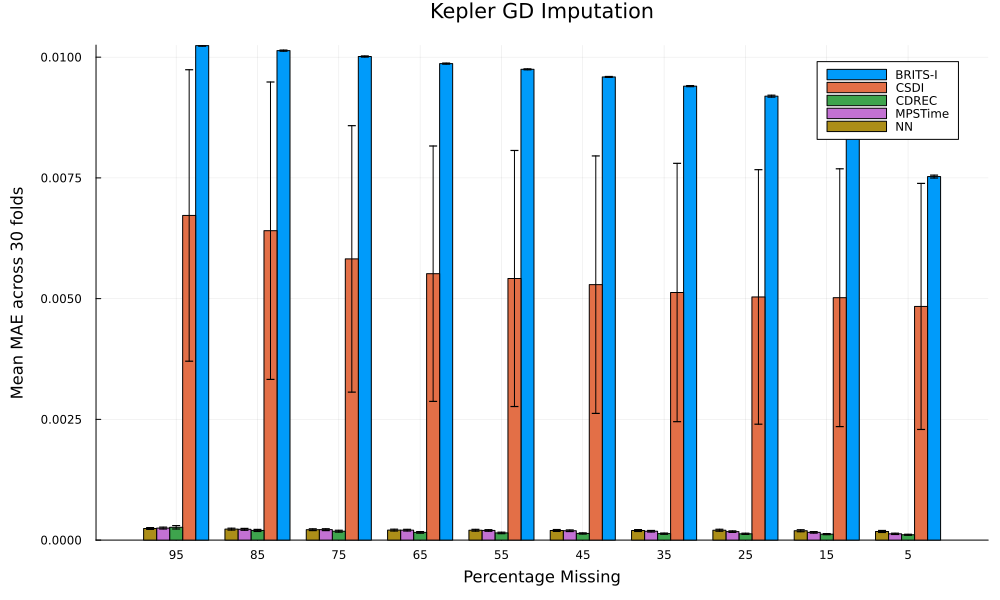

In [24]:
groupedbar(
    pms, 
    [ mean(mmae_kepGD_britsi, dims=1)' mean(mmae_kepGD_csdi, dims=1)' mean(mmae_kepGD_cdrec, dims=1)' mean(mmae_kepGD, dims=1)'  mean(mmae_kepGD_nn, dims=1)' ]; 
    yerr =1.96 .* [ mean(std_kepGD_britsi, dims=1)' mean(std_kepGD_csdi, dims=1)' mean(std_kepGD_cdrec, dims=1)' mean(std_kepGD, dims=1)'  mean(std_kepGD_nn, dims=1)' ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "BRITS-I" "CSDI" "CDREC" "MPSTime"  "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Kepler GD Imputation")
# savefig("KepGD-lol.png")

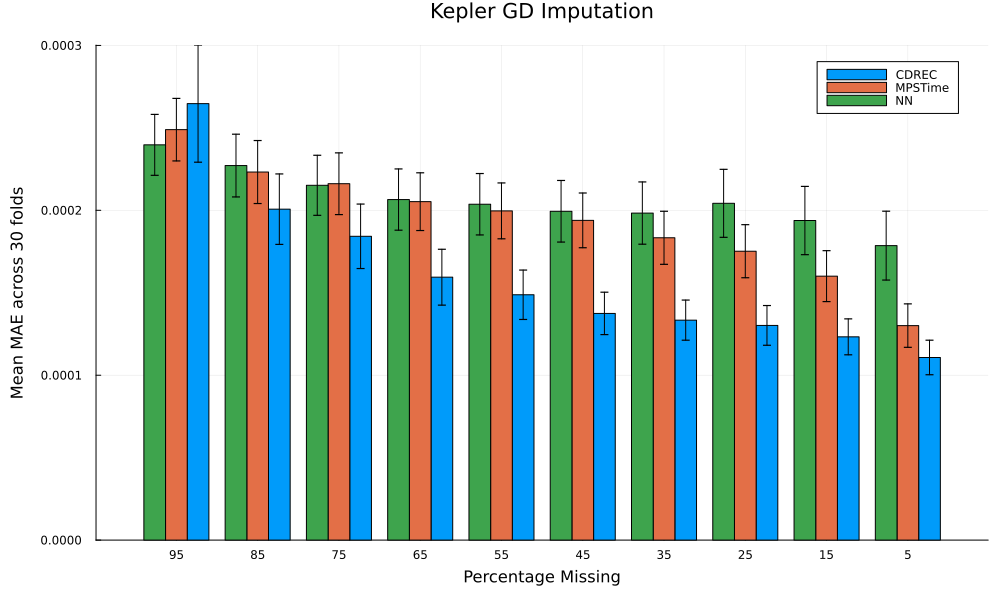

In [23]:
groupedbar(
    pms, 
    [ mean(mmae_kepGD_cdrec, dims=1)' mean(mmae_kepGD, dims=1)'  mean(mmae_kepGD_nn, dims=1)' ]; 
    yerr =1.96 .* [  mean(std_kepGD_cdrec, dims=1)' mean(std_kepGD, dims=1)'  mean(std_kepGD_nn, dims=1)' ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "CDREC" "MPSTime"  "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Kepler GD Imputation")
# savefig("KepGD-good.png")

In [88]:
mmae_kepC6_nn, std_kepC6_nn = mmae_nn_c6, std_nn_c6
@save "Kepler_mps_and_nn.jld2" mmae_kepC6 std_kepC6 mmae_kepC6_nn std_kepC6_nn mmae_kepGD std_kepGD mmae_kepGD_nn std_kepGD_nn

# Kepler Heatmaps

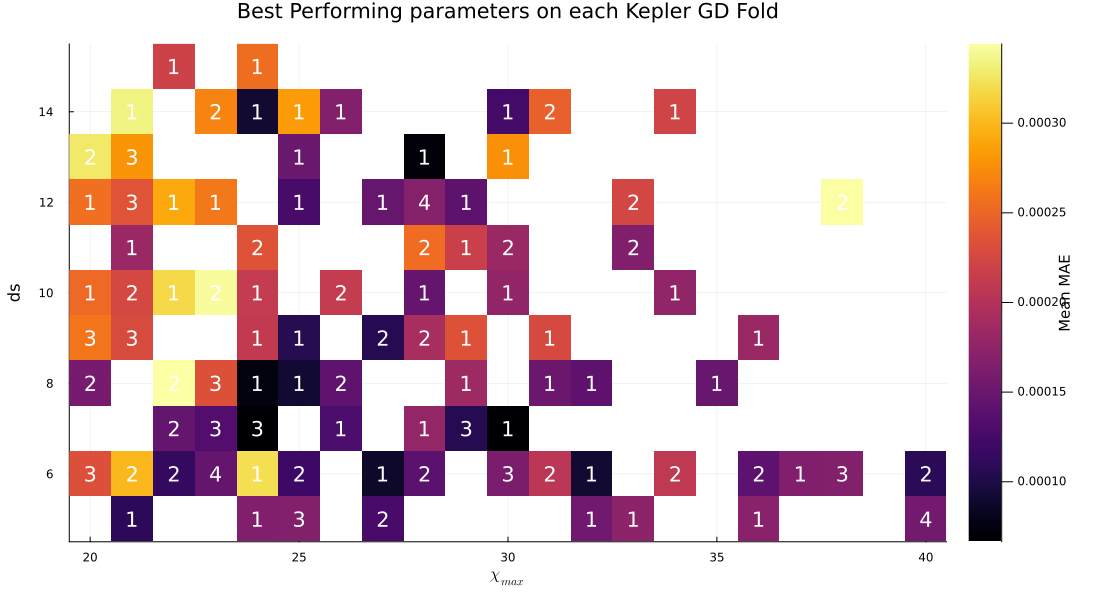

In [36]:
ds, chis, losses, anns = get_hm_vals(reduce(vcat,res_kepGD))
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each Kepler GD Fold")
plot(hm)
# savefig("KepGD_heatmap.png")


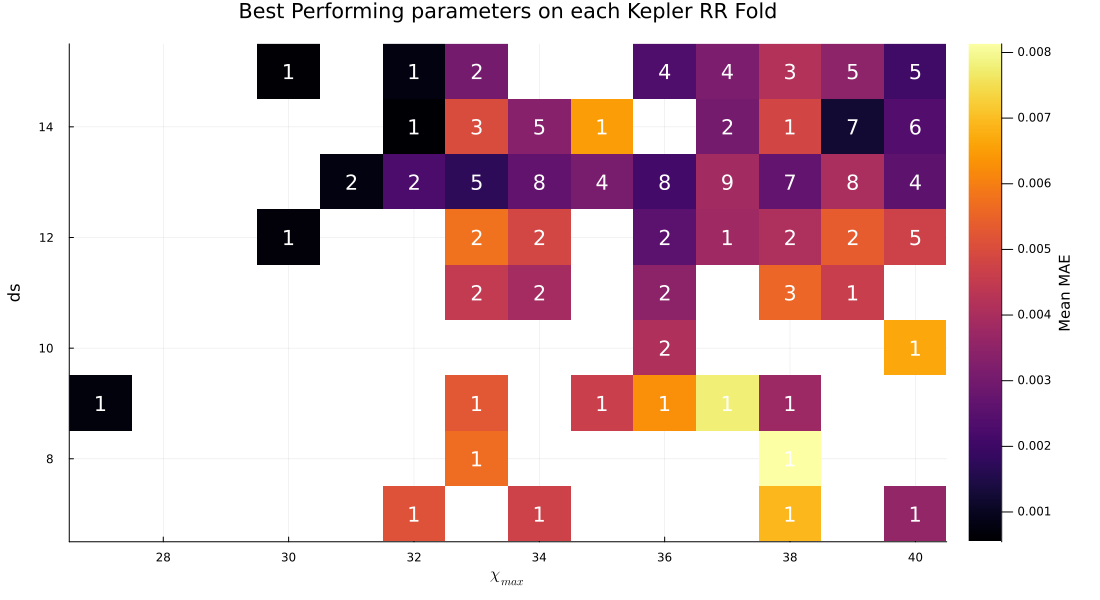

In [35]:
ds, chis, losses, anns = get_hm_vals(reduce(vcat,res_kepC6))
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each Kepler RR Fold")
plot(hm)
# savefig("KepRR_heatmap.png")


# Generate GD nearest neighbour data

In [67]:
@load "Kepler/kepler_windows_julia_idx.jld2" windows_per_percentage
# windows_julia = windows_per_percentage
eval_windows = reduce(vcat, values(windows_per_percentage))


rs_f = jldopen("Kepler/GD_folds_per_inst.jld2", "r");
    folds = read(rs_f, "folds");
    Xs = read(rs_f, "Xs_per_inst");
close(rs_f)


In [69]:
loss_NN_per_inst = []
# loss_median = mean(MPSTime.eval_loss(ImputationLoss(), mps, X_test, [0,0], eval_windows) )
for inst in 1:5
    loss_NN = []
        # properties = propertynames(opts_re)

    for (i,fold) in enumerate(folds[inst])
        tr_inds, te_inds = fold
        X_train, X_test = Xs[inst][tr_inds,:], Xs[inst][te_inds,:]
        opts_re = kepGD_opts[inst][i]

        properties = propertynames(opts_re)
        opts = MPSOptions(; [field => getproperty(opts_re,field) for field in properties]..., nsweeps=0)
        mps, _... = fitMPS(X_train, opts);

        imp = init_imputation_problem(mps, X_test; verbosity=-10);

        push!(loss_NN, Dict("eval_windows"=>eval_windows,
                            "loss"=>MPSTime.eval_loss(ImputationLoss(), mps, X_test, zeros(Int,length(te_inds)), eval_windows, method=:kNearestNeighbour)
                        )
        )

    end
    push!(loss_NN_per_inst, loss_NN)
end

@save "Kepler/KCGD_nn/insts_1_to_5.jld2" loss_NN_per_inst

In [74]:
loss_NN_per_inst[2][6]

Dict{String, Vector} with 2 entries:
  "eval_windows" => [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  57, 58, 59, 60, 61, 62…
  "loss"         => [0.000150285, 0.000197993, 0.000186007, 0.000211224, 0.0001…

In [92]:
inst = 1
fnum = 1
fold = folds[inst][fnum]

tr_inds, te_inds = fold
X_train, X_test = Xs[inst][tr_inds,:], Xs[inst][te_inds,:]
opts_re = kepGD_opts[inst][fnum]

properties = propertynames(opts_re)
opts = MPSOptions(; [field => getproperty(opts_re,field) for field in properties]...)
mps, _... = fitMPS(X_train, opts);

imp = init_imputation_problem(mps, X_test; verbosity=-10);

1-element Vector{Any}:
 Dict(:MAE => 0.00031691198712200644, :MAPE => 1.498548942222589, :NN_MAE => 0.0002910555462150155, :NN_MAPE => 1.7235477545613156)

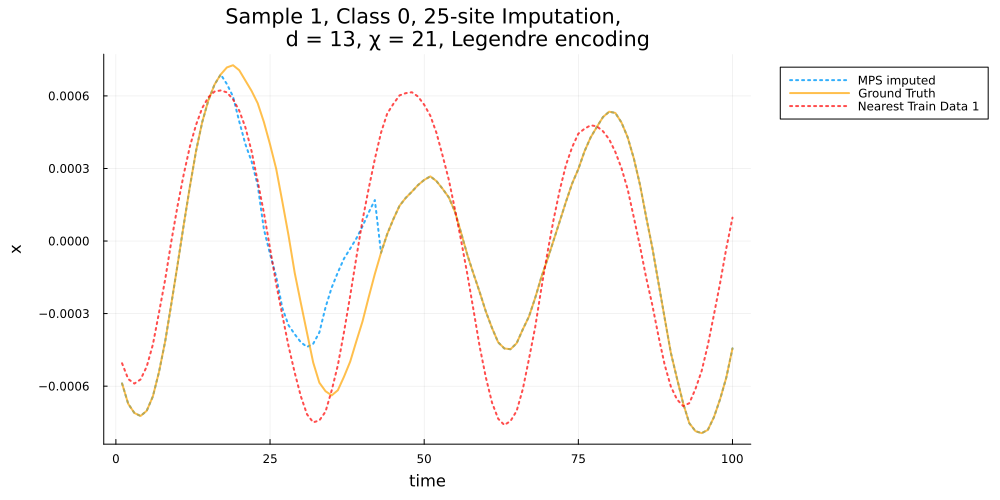

In [99]:
impute_sites = eval_windows[100]
method=:median
class = 0
inst = 1
imputed, errs, targets, stats, plots = MPS_impute(imp, class, inst, impute_sites, method; NN_baseline=true, plot_fits=true)

display(stats)
plot(plots...)